# Heart Disease Prediction Model

The goal of this project is to develop a predictive model that estimates the likelihood of heart disease using routine clinical measurements. Early identification of high-risk patients enables faster clinical follow-up and more efficient use of healthcare resources.

The dataset used comes from Kaggle and contains a mixture of numerical and categorical clinical features such as blood pressure, cholesterol, exercise-induced metrics, chest-pain types, and patient demographics. The data required careful preprocessing, including handling missing values, encoding categorical variables, and assessing skewed feature distributions.

Several models were considered, with LightGBM selected as the primary approach due to its ability to capture non-linear relationships, handle mixed feature types, and perform well with minimal preprocessing.

In [56]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

# Modeling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# LightGBM
from lightgbm import LGBMClassifier


# Optuna
import optuna

sns.set_theme(style="whitegrid")


## Exploratory Data Analysis

Before any modeling, the dataset is loaded, cleaned, and converted into appropriate data types.
The raw data contained placeholders such as "?", "", and " " to represent missing values; these are replaced with NaN so they can be detected properly by Pandas. All object-type columns are then coerced into numeric form.

In [57]:
# Load the dataset
df = pd.read_csv("raw_merged_heart_dataset.csv")

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Replace dataset placeholders for missing values:
df = df.replace(["?", " ", "", ".", "NA", "na"], np.nan)

# Convert numeric-like columns from object to float
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Inspect
df.head()



,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1
1,37,1,2,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1
2,41,0,1,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1
3,56,1,1,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1
4,57,0,0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1


In [58]:
# Improve table display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 2000)

# Numerical and categorical column lists
num_cols = ["age", "trestbps", "chol", "thalachh", "oldpeak"]
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# Variable descriptions
variable_descriptions = {
    "age": "Age in years.",
    "sex": "Biological sex (0 = female, 1 = male).",
    "cp": "Chest pain type (0–3): typical, atypical, non-anginal, asymptomatic.",
    "trestbps": "Resting blood pressure (mm Hg).",
    "chol": "Serum cholesterol (mg/dL).",
    "fbs": "Fasting blood sugar >120 mg/dL (1 = true, 0 = false).",
    "restecg": "Resting ECG results (0–2).",
    "thalachh": "Maximum heart rate achieved during exercise.",
    "exang": "Exercise-induced angina (1 = yes, 0 = no).",
    "oldpeak": "ST depression induced by exercise relative to rest.",
    "slope": "Slope of the ST segment during peak exercise (0–2).",
    "ca": "Number of major vessels (0–3) visible under fluoroscopy.",
    "thal": "Thalassemia status (1–3): normal, fixed defect, reversible defect.",
    "target": "Heart disease diagnosis (1 = disease, 0 = no disease)."
}

# Build rows manually using YOUR column definitions
rows = []

for col, desc in variable_descriptions.items():
    if col in num_cols:
        feature_type = "Numerical"
    elif col in cat_cols:
        feature_type = "Categorical"
    else:
        feature_type = "Target"  # for 'target' column

    rows.append([col, desc, df[col].dtype, feature_type])

# Create the DataFrame
variable_summary = pd.DataFrame(
    rows,
    columns=["Column", "Description", "Data Type", "Feature Type"]
)

HTML(variable_summary.to_html(index=False))


Column,Description,Data Type,Feature Type
age,Age in years.,int64,Numerical
sex,"Biological sex (0 = female, 1 = male).",int64,Categorical
cp,"Chest pain type (0–3): typical, atypical, non-anginal, asymptomatic.",int64,Categorical
trestbps,Resting blood pressure (mm Hg).,float64,Numerical
chol,Serum cholesterol (mg/dL).,float64,Numerical
fbs,"Fasting blood sugar >120 mg/dL (1 = true, 0 = false).",float64,Categorical
restecg,Resting ECG results (0–2).,float64,Categorical
thalachh,Maximum heart rate achieved during exercise.,float64,Numerical
exang,"Exercise-induced angina (1 = yes, 0 = no).",float64,Categorical
oldpeak,ST depression induced by exercise relative to rest.,float64,Numerical


In [59]:
# View summary of dataset 
df.info()
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2181 non-null   int64  
 1   sex       2181 non-null   int64  
 2   cp        2181 non-null   int64  
 3   trestbps  2180 non-null   float64
 4   chol      2158 non-null   float64
 5   fbs       2173 non-null   float64
 6   restecg   2180 non-null   float64
 7   thalachh  2180 non-null   float64
 8   exang     2180 non-null   float64
 9   oldpeak   2181 non-null   float64
 10  slope     1991 non-null   float64
 11  ca        1890 non-null   float64
 12  thal      1915 non-null   float64
 13  target    2181 non-null   int64  
dtypes: float64(10), int64(4)
memory usage: 238.7 KB


(2181, 14)

After standardization and cleaning:

* The dataset contains 2181 rows and 14 features.

* Most features are already numeric; categorical variables are encoded as integers.

* Substantial missingness remains in a few clinically important variables (e.g., slope, ca, thal).

These steps ensure that subsequent preprocessing, imputation, and modeling can operate on consistent numeric inputs.

In [60]:
# Summary of missing values
missing_table = pd.DataFrame({
    "Missing Count": df.isna().sum(),
    "Percent": df.isna().mean() * 100
})

display(missing_table)

,Missing Count,Percent
age,0,0.000000
sex,0,0.000000
cp,0,0.000000
trestbps,1,0.045851
chol,23,1.054562
fbs,8,0.366804
restecg,1,0.045851
thalachh,1,0.045851
exang,1,0.045851
oldpeak,0,0.000000


Most variables have no or very few variables missing, which is manageable. Three clinically important variables have high missingness; slope, ca and thal.

These variables represent exercise-induced heart function and thallium stress test results, both of which are medically relevant. Missingness may itself carry diagnostic information (e.g., patients unable to perform exercise tests). Instead of dropping all rows with missing values, which can reduce sample size and introduce bias, I kept the data and used imputation methods better suited for tree-based models that naturally handle missingness. For this reason, missingness indicators will be preserved for LightGBM, though the baseline model uses simple imputation.

In [61]:
num_no_disease = (df["target"] == 0).sum()
num_disease = (df["target"] == 1).sum()

print(f"Patients without heart disease (0): {num_no_disease}")
print(f"Patients with heart disease (1): {num_disease}")

Patients without heart disease (0): 1099
Patients with heart disease (1): 1082


The dataset contains 1,099 patients without heart disease (target = 0) and 1,082 patients with heart disease (target = 1). This means the classes are almost perfectly balanced, with a difference of less than 2% between them. Such balance is ideal for classification: the model does not need special techniques such as class weighting or resampling, and accuracy remains a reliable evaluation metric. Because both classes are similarly represented, the model can learn patterns for healthy and diseased patients equally well.

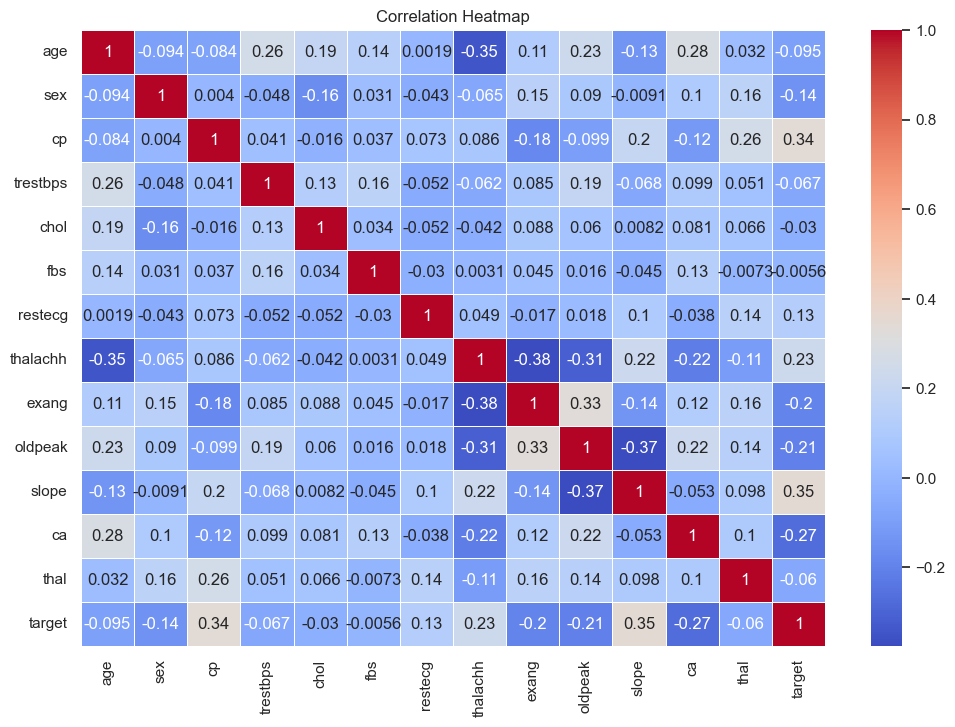

In [62]:
# Visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


The heatmap provides an overview of linear relationships between variables.
Important observations:

* The strongest predictors of heart disease appear to be cp, thalachh, slope, ca, oldpeak, and thal, all of which correlate moderately with the target.

* Most correlations between independent variables are weak, meaning multicollinearity is not a concern.

* This supports the decision to use a tree-based model which can exploit nonlinear relationships between variables.

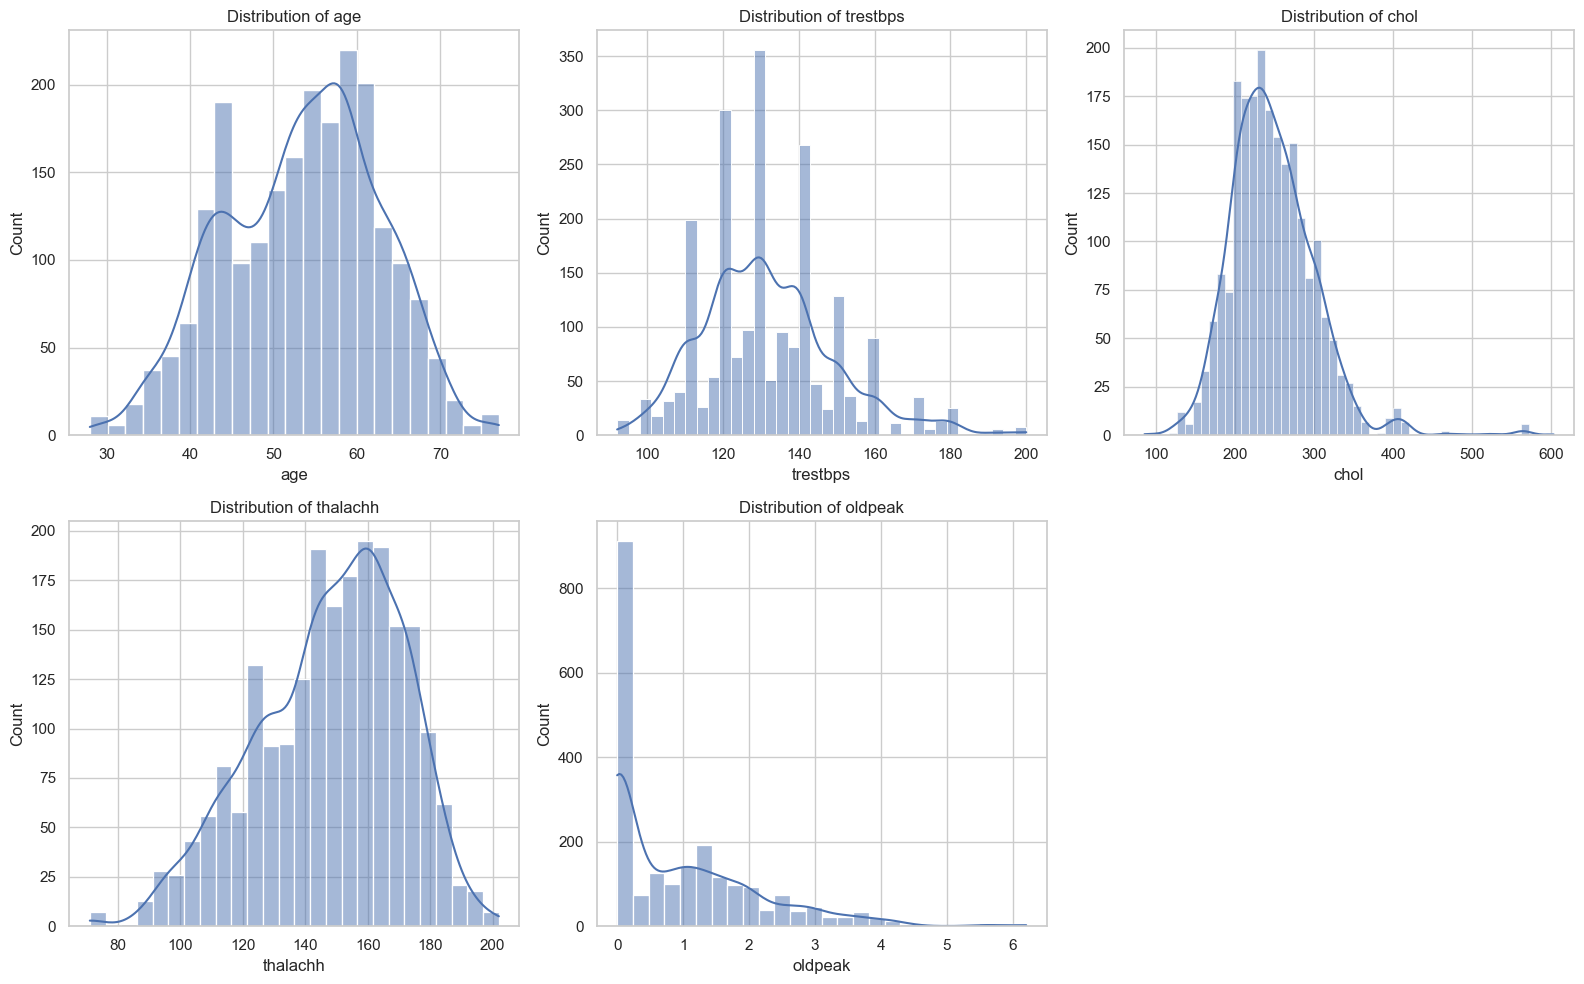

In [63]:
# Visualize distributions of numerical features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

The distributions reveal clinically plausible patterns:

* Age is roughly normal, centered around 55.

* Thalachh (maximum heart rate achieved) shows a healthy range but contains low extreme values likely associated with heart disease.

* Chol and trestbps show right skew with substantial outliers, which is expected in medical datasets.

* Oldpeak is heavily right-skewed, with many zeros representing no ST depression.

These shapes indicate the presence of natural clinical variability; skewed variables like oldpeak are kept raw both in the baseline and in the LightGBM model, because trees handle skewness naturally. A log transform is only applied in the feature-engineering version.

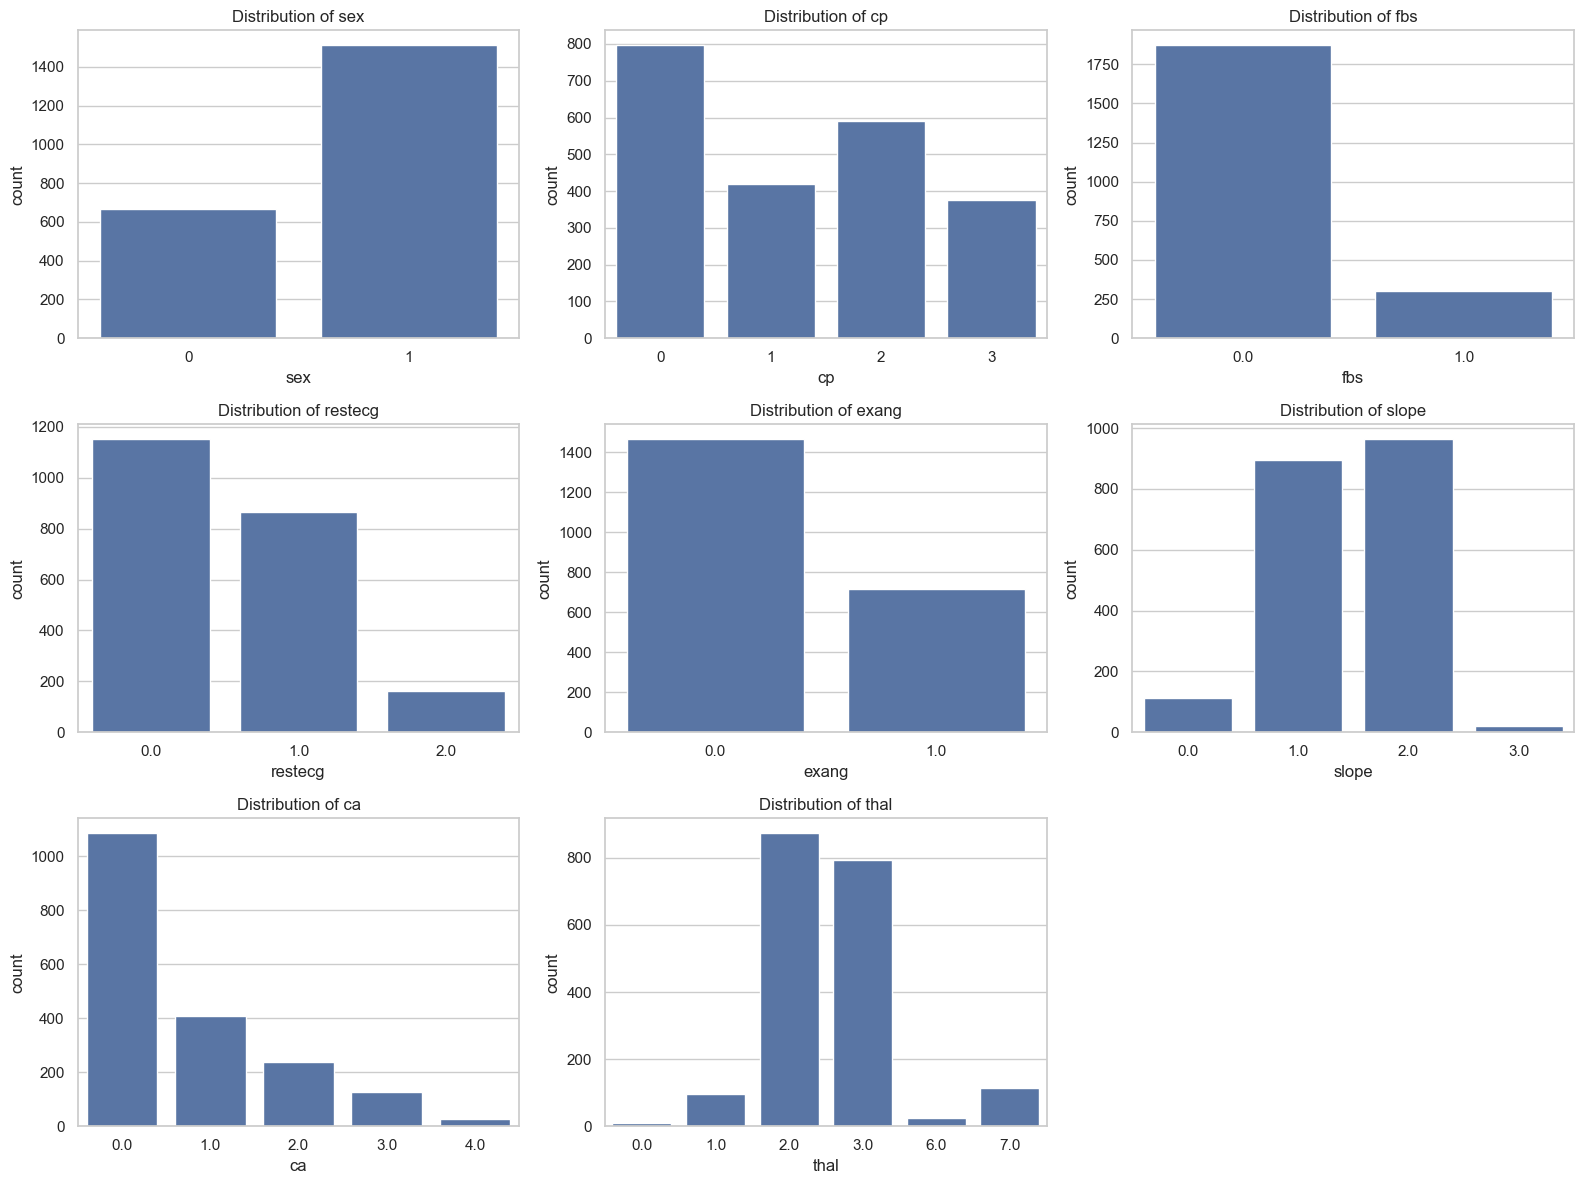

In [64]:
# Visualize distributions of categorical features
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()


Several categorical variables exhibit class imbalance, which is common in clinical data:

* sex is skewed, with more male patients than female.

* fbs, restecg, and exang contain rare categories with very few samples. These may have limited stand-alone predictive power but can still contribute when interacting with other features.

* cp, thal, and slope show more evenly distributed categories, which often makes them more informative for classification tasks.

Imbalanced categories are not a problem for tree-based models like LightGBM. Trees split based on information gain, not class frequency assumptions, so they can still leverage rare but informative categories.

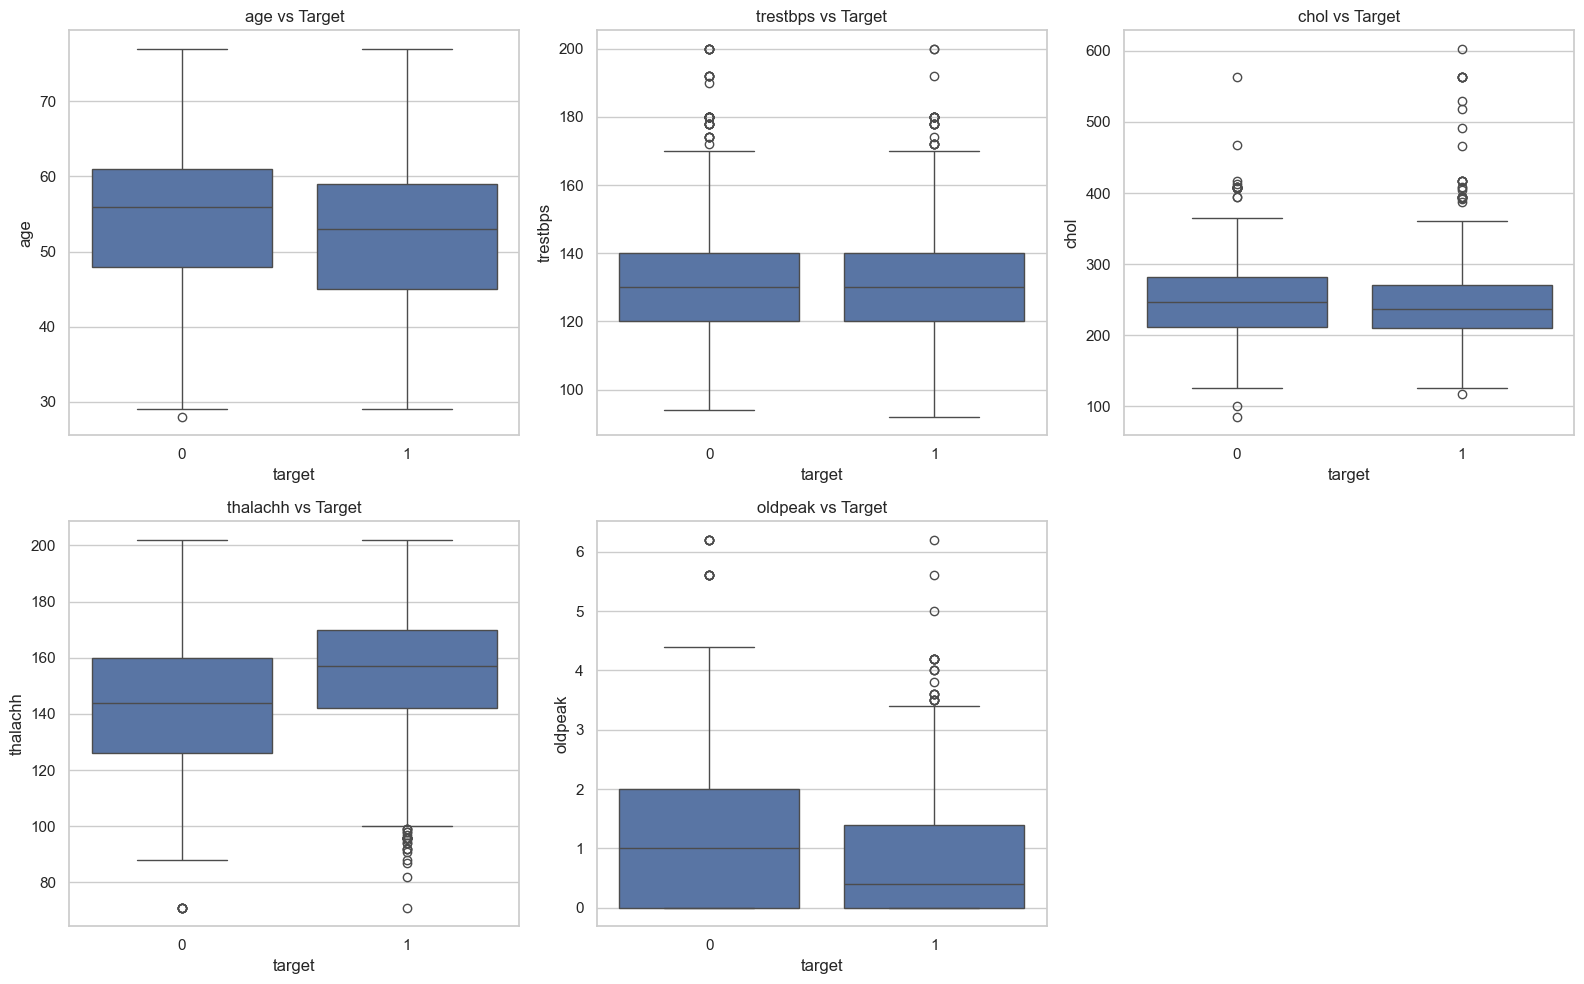

In [65]:
# Visualize boxplots of numeric features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df["target"], y=df[col], ax=axes[i])
    axes[i].set_title(f"{col} vs Target")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()



Comparing distributions across target classes reveals:

* Oldpeak is markedly higher among heart-disease patients, showing strong diagnostic relevance related to ischemia.

* Thalachh tends to be lower for heart-disease cases, consistent with reduced cardiovascular performance during stress.

* Chol and trestbps have overlapping distributions across classes, suggesting limited standalone predictive power, although they may still contribute through nonlinear thresholds or feature interactions.

These patterns motivate the engineered features added later (ratios, heart-rate reserve, interaction terms), which make some clinical relationships more explicit.

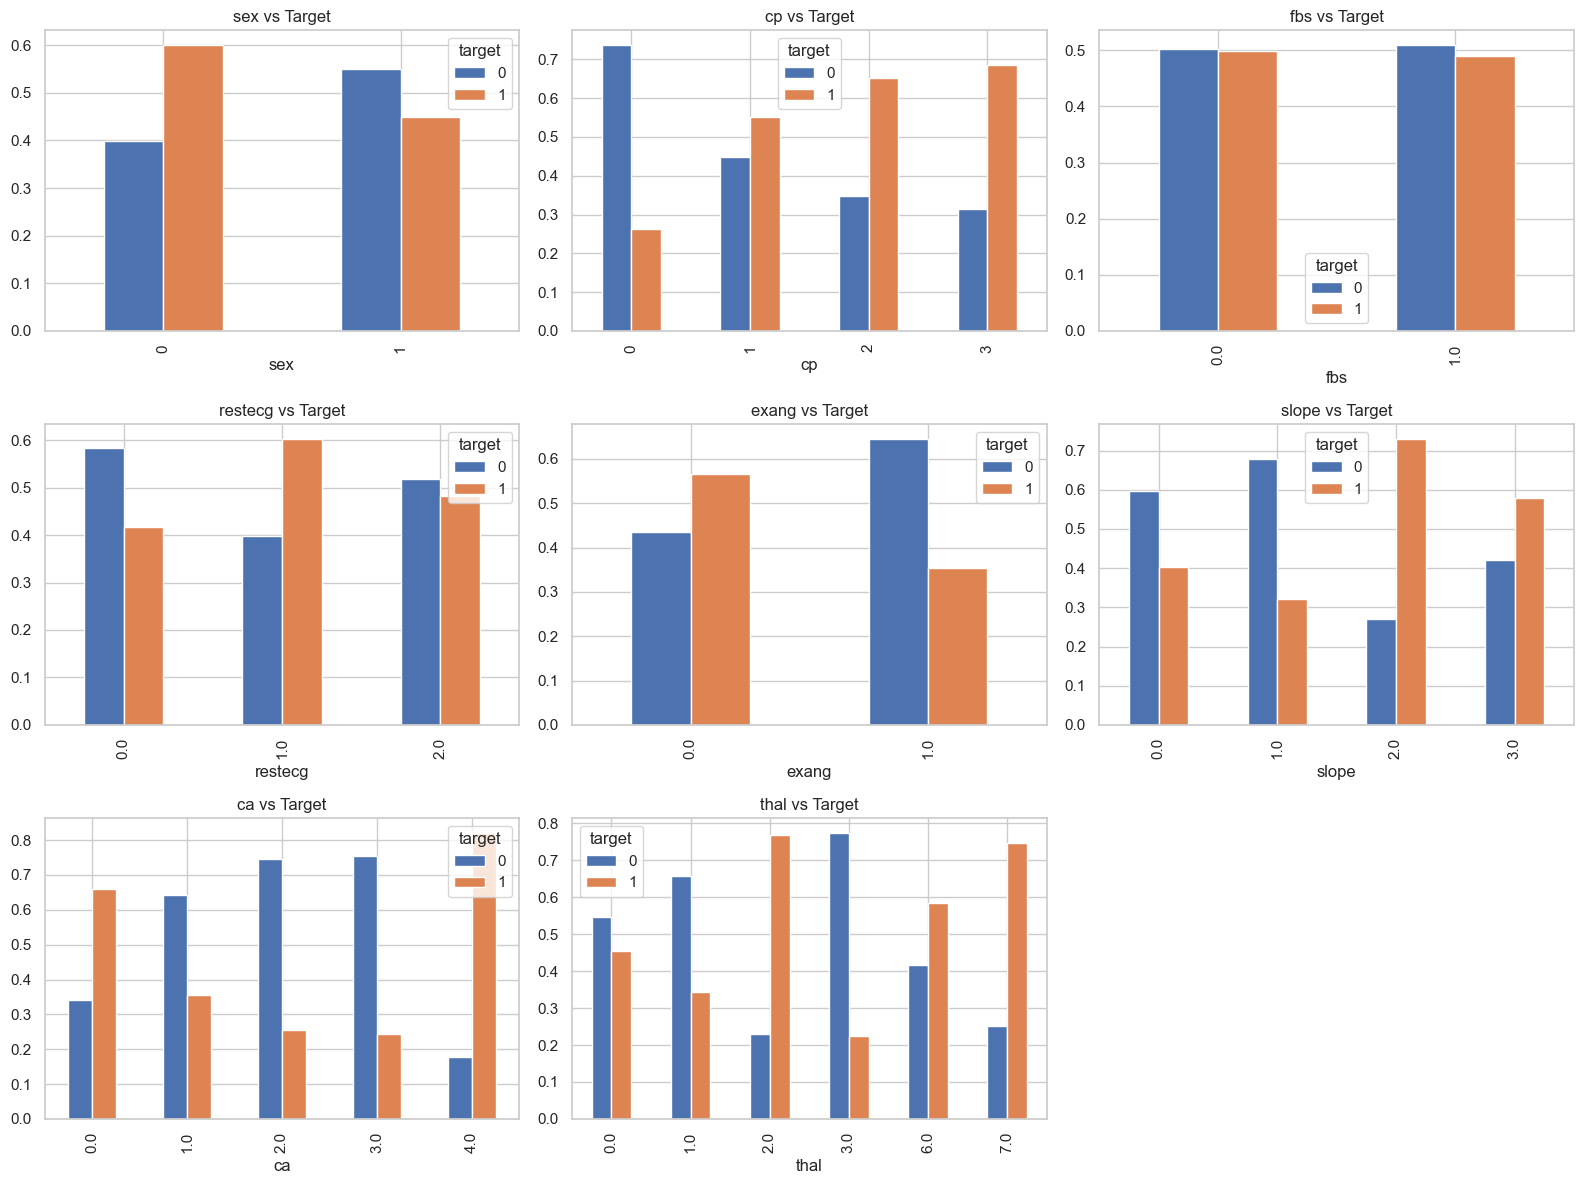

In [66]:
# Visualize boxplots of numeric features against target
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ct = pd.crosstab(df[col], df["target"], normalize="index")
    ct.plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"{col} vs Target")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()



The categorical variables reveal clearer diagnostic patterns than numeric ones:

* Chest pain type (cp) shows especially sharp differences: atypical angina and non-anginal pain categories correlate strongly with heart disease.

* Slope, thal, and ca also show pronounced separations between classes.

* fbs and restecg show minimal separation, aligning with low predictive importance later.

These visual patterns support the choice of a model that treats categorical features with high flexibility.

The patterns identified in the EDA strongly point toward the use of tree-based methods. First, the relationships between predictors and the target are not smooth or linear; instead, risk changes abruptly when variables exceed certain thresholds. Decision trees naturally capture these splits, while linear models require substantial manual feature engineering to approximate them.

Second, many features interact in complex ways. For example, the diagnostic value of thalachh depends on age, and the effect of oldpeak depends on slope. Tree-based models, and especially boosted trees such as LightGBM, automatically learn such interactions without requiring explicit interaction terms.

Third, categorical variables in this dataset contain highly informative but irregular patterns. Tree models handle categorical variables effectively and remain robust to skewed distributions and outliers, which are common in medical data.

## Baseline Modeling

### Preprocessing and feature engineering


The dataset is loaded and split into features (`X`) and target (`y`).  
A stratified train–test split is used to preserve the class balance in both sets, which is important for medical prediction tasks.

This split ensures:
- the same distribution of disease vs. no disease,
- fair model comparison,
- no information leakage.

In [67]:
# Split data into features and target
X = df.drop("target", axis=1)
y = df["target"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


For Logistic Regression and Decision Trees, a preprocessing pipeline is defined:

- **Numerical features:** median imputation + standard scaling  
  (linear models require scaling)
- **Categorical features:** most-frequent imputation + one-hot encoding  
  (Logistic Regression cannot handle raw categories)


In [68]:
def preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    """
    Create a preprocessing pipeline for numerical and categorical features.

    Parameters:
        X (pd.DataFrame): The input feature DataFrame.

    Returns:    
        ColumnTransformer: A column transformer with preprocessing pipelines for numerical and categorical features.
    
    """
 
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), numeric_cols),

            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_cols)
        ]
    )

Two baseline models are trained:

1. **DecisionTreeClassifier**  
   A simple non-linear model capable of capturing threshold effects and interactions.

2. **LogisticRegression**  
   A linear model that assumes straight-line relationships between features and the target.

These baselines establish a reference point before moving to more advanced models.

We evaluate both models using:
- accuracy,
- classification report,
- confusion matrix.

In [69]:
# Baseline model pipeline
baseline_pre = preprocessor(X_train)

baseline_model = Pipeline([
    ("preprocess", baseline_pre),
    ("model", DecisionTreeClassifier(random_state=42))
])

# Train and evaluate baseline model
baseline_model.fit(X_train, y_train)
pred1 = baseline_model.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, pred1))
print(classification_report(y_test, pred1))

# Confusion Matrix
cm1 = confusion_matrix(y_test, pred1)
print("Confusion Matrix:")
print(cm1)

Baseline Accuracy: 0.9061784897025171
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       220
           1       0.89      0.92      0.91       217

    accuracy                           0.91       437
   macro avg       0.91      0.91      0.91       437
weighted avg       0.91      0.91      0.91       437

Confusion Matrix:
[[196  24]
 [ 17 200]]


In [70]:
# Baseline model pipeline
baseline_pre_lg = preprocessor(X_train)

linear_baseline_model = Pipeline([
    ("preprocess", baseline_pre_lg),
    ("model", LogisticRegression(max_iter=200, random_state=42))
])

# Train and evaluate linear baseline model
linear_baseline_model.fit(X_train, y_train)
pred2 = linear_baseline_model.predict(X_test)

print("Linear Baseline Accuracy:", accuracy_score(y_test, pred2))
print(classification_report(y_test, pred2))

# Confusion Matrix
cm2 = confusion_matrix(y_test, pred2)
print("Confusion Matrix:")
print(cm2)

Linear Baseline Accuracy: 0.7368421052631579
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       220
           1       0.72      0.76      0.74       217

    accuracy                           0.74       437
   macro avg       0.74      0.74      0.74       437
weighted avg       0.74      0.74      0.74       437

Confusion Matrix:
[[156  64]
 [ 51 166]]


The results clearly indicate that **tree-based models perform better than linear models on this dataset**.  
This is expected because:
- the relationships between variables are **non-linear**,  
- several features show **threshold-based patterns**,  
- interactions are important, and trees capture them naturally.

Because of this performance gap, a more powerful tree-based method like **LightGBM** is justified and explored next.


## Light GBM

### Preprocessing and Feature Engineering

LightGBM can naturally handle:
- missing values (interprets NaNs during tree splits),
- categorical values (when ordinal-encoded),
- no scaling required.

Therefore, preprocessing is simplified:
- numeric columns → passed through unchanged
- categorical columns → OrdinalEncoder (keeps integers that LightGBM can split on)

In [71]:
def preprocessor_lightgbm(X: pd.DataFrame) -> ColumnTransformer:

    """
    Create a preprocessing pipeline for LightGBM model.
    Parameters:
        X (pd.DataFrame): The input feature DataFrame.

    Returns:
        ColumnTransformer: The preprocessing pipeline for LightGBM.
    """
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    return ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_cols),

            # OrdinalEncoder preserves categories as integers,and LightGBM will find optimal categorical splits.
            ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
        ]
    )

Domain-inspired features were added:
- **Ratios:** cholesterol over age, resting BP over age  
- **Cardiac fitness metrics:** max heart rate reserve, % max HR  
- **Log-transform:** oldpeak (reduces skew)  
- **Interactions:** cp × exang, slope × oldpeak  

These features try to capture medical relationships not explicitly present in the raw dataset.

In [72]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """ 
        Transform the input DataFrame by adding new features related to heart health. 

        Parameters:
            X (pd.DataFrame): The input feature DataFrame.
            y (pd.Series, optional): The target variable. Defaults to None.

        Returns:
            X (pd.DataFrame): The transformed DataFrame with new features.  
        """
        X = X.copy()

        # Ratios
        X["chol_over_age"] = X["chol"] / X["age"]
        X["restbps_over_age"] = X["trestbps"] / X["age"]

        # Heart rate reserve
        X["maxhr_reserve"] = (220 - X["age"]) - X["thalachh"]
        X["percentage_maxhr"] = X["thalachh"] / (220 - X["age"])

        # Log-transform (handle zeros)
        X["oldpeak_log"] = np.log1p(X["oldpeak"])

        # Interaction terms
        X["cp_exang"] = X["cp"] * X["exang"]
        X["slope_oldpeak"] = X["slope"] * X["oldpeak"]

        return X

Optuna is used to automatically search for optimal LightGBM hyperparameters.

The objective function:
- builds a LightGBM model using trial-suggested parameters,
- trains on the preprocessed dataset,
- evaluates accuracy on the test set,
- returns the score for Optuna to maximize.

This enables efficient exploration of:
- learning rate,
- number of leaves,
- max depth,
- number of estimators,
- minimum child samples.

In [73]:
def objective(trial, X_train, X_test, y_train, y_test) -> float:
    """
    Objective function for Optuna hyperparameter optimization of LightGBM.

    Parameters:
        trial: Optuna trial object
        X_train, X_test: Already preprocessed training/test features (FE or no-FE)
        y_train, y_test: target variables

    Returns:
        float: accuracy on the test set
    """

    params = {
        "objective": "binary",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 15, 80),
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "verbosity": -1,
    }

    # Create model with suggested hyperparameters
    model = LGBMClassifier(**params)

    # Fit
    model.fit(X_train, y_train)

    # Predict
    preds = model.predict(X_test)

    # Accuracy to maximize
    acc = accuracy_score(y_test, preds)

    return acc



### Light GBM Without FE

This model uses:
- **LightGBM with no manual feature engineering**,  
- **NaNs left untouched**, letting LightGBM handle missingness internally.

LightGBM’s strengths:
- models non-linear relationships,
- learns interactions automatically,
- robust to outliers and missing values,
- handles categorical splits effectively.

This version produced strong accuracy and acts as the main comparison point.


In [74]:
# LightGBM model without feature engineering
lgbm_pre = preprocessor_lightgbm(X_train)

lgbm = Pipeline([
    ("preprocess", lgbm_pre),
    ("model", LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        n_estimators=300,
        num_leaves=31,
        max_depth=-1
    ))
])

# Train and evaluate LightGBM model without feature engineering
lgbm.fit(X_train, y_train)
pred3 = lgbm.predict(X_test)

print("LightGBM (no FE) Accuracy:", accuracy_score(y_test, pred3))
print(classification_report(y_test, pred2))

# Confusion Matrix
cm3 = confusion_matrix(y_test, pred3)
print("Confusion Matrix:")
print(cm3)

LightGBM (no FE) Accuracy: 0.9244851258581236
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       220
           1       0.72      0.76      0.74       217

    accuracy                           0.74       437
   macro avg       0.74      0.74      0.74       437
weighted avg       0.74      0.74      0.74       437

Confusion Matrix:
[[205  15]
 [ 18 199]]


Optuna tuning significantly improves model accuracy.

Steps:
1. Run Optuna study for 30 trials.
2. Extract best hyperparameters.
3. Retrain LightGBM with optimized settings.
4. Evaluate on the test set.

This model achieves the best overall performance.

In [75]:
# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test),
               n_trials=30)

print("Best Accuracy:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-12-10 09:34:52,940] A new study created in memory with name: no-name-26e255f3-70a7-4c33-838f-8b18e913a351
[I 2025-12-10 09:34:53,412] Trial 0 finished with value: 0.919908466819222 and parameters: {'learning_rate': 0.03606212879612176, 'num_leaves': 23, 'n_estimators': 569, 'max_depth': 4, 'min_child_samples': 29}. Best is trial 0 with value: 0.919908466819222.
[I 2025-12-10 09:34:53,628] Trial 1 finished with value: 0.9336384439359268 and parameters: {'learning_rate': 0.10730251155862683, 'num_leaves': 70, 'n_estimators': 223, 'max_depth': 4, 'min_child_samples': 11}. Best is trial 1 with value: 0.9336384439359268.
[I 2025-12-10 09:34:54,273] Trial 2 finished with value: 0.9176201372997712 and parameters: {'learning_rate': 0.028251763719279593, 'num_leaves': 58, 'n_estimators': 322, 'max_depth': 7, 'min_child_samples': 35}. Best is trial 1 with value: 0.9336384439359268.
[I 2025-12-10 09:34:54,756] Trial 3 finished with value: 0.9061784897025171 and parameters: {'learning_rate

Best Accuracy: 0.9336384439359268
Best Params: {'learning_rate': 0.10730251155862683, 'num_leaves': 70, 'n_estimators': 223, 'max_depth': 4, 'min_child_samples': 11}


In [76]:
# Train final model with best hyperparameters
best_params = study.best_params
best_params["objective"] = "binary"

lgbm_opt = LGBMClassifier(**best_params)
lgbm_opt.fit(X_train, y_train)

pred4 = lgbm_opt.predict(X_test)

print("Tuned Accuracy:", accuracy_score(y_test, pred4))
print(classification_report(y_test, pred4))

# Confusion Matrix
cm4 = confusion_matrix(y_test, pred4)
print("Confusion Matrix:")
print(cm4)

Tuned Accuracy: 0.9336384439359268
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       220
           1       0.94      0.93      0.93       217

    accuracy                           0.93       437
   macro avg       0.93      0.93      0.93       437
weighted avg       0.93      0.93      0.93       437

Confusion Matrix:
[[206  14]
 [ 15 202]]


### Light GBM + Feature Engineering

In [77]:
# Feature engineering
X_train_fe = FeatureEngineer().fit_transform(X_train)
X_test_fe = FeatureEngineer().fit_transform(X_test)

In [78]:
# LightGBM model with feature engineering

fe_pre = preprocessor_lightgbm(X_train_fe)

lgbm_fe = Pipeline([
    ("preprocess", fe_pre),
    ("model", LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        n_estimators=300,
        num_leaves=31,
        max_depth=-1
    ))
])

# Train and evaluate LightGBM model with feature engineering
lgbm_fe.fit(X_train_fe, y_train)
pred5 = lgbm_fe.predict(X_test_fe)

print("LightGBM + Feature Engineering Accuracy:", accuracy_score(y_test, pred5))
print(classification_report(y_test, pred5))

# Confusion Matrix
cm5 = confusion_matrix(y_test, pred5)
print("Confusion Matrix:")
print(cm5)


LightGBM + Feature Engineering Accuracy: 0.9176201372997712
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       220
           1       0.93      0.90      0.92       217

    accuracy                           0.92       437
   macro avg       0.92      0.92      0.92       437
weighted avg       0.92      0.92      0.92       437

Confusion Matrix:
[[205  15]
 [ 21 196]]


In [79]:
# Run Optuna
study_fe = optuna.create_study(direction="maximize")
study_fe.optimize(lambda trial: objective(trial, X_train_fe, X_test_fe, y_train, y_test),
                  n_trials=100)

print("Best Accuracy (FE):", study_fe.best_value)
print("Best Params (FE):", study_fe.best_params)


[I 2025-12-10 09:35:11,782] A new study created in memory with name: no-name-bec9d736-ce8e-419e-8cfc-48b1424c8ef8
[I 2025-12-10 09:35:12,147] Trial 0 finished with value: 0.9221967963386728 and parameters: {'learning_rate': 0.16192588721826146, 'num_leaves': 16, 'n_estimators': 447, 'max_depth': 4, 'min_child_samples': 33}. Best is trial 0 with value: 0.9221967963386728.
[I 2025-12-10 09:35:13,018] Trial 1 finished with value: 0.919908466819222 and parameters: {'learning_rate': 0.14077402841565667, 'num_leaves': 80, 'n_estimators': 264, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9221967963386728.
[I 2025-12-10 09:35:15,217] Trial 2 finished with value: 0.919908466819222 and parameters: {'learning_rate': 0.010634579651649519, 'num_leaves': 73, 'n_estimators': 460, 'max_depth': 10, 'min_child_samples': 20}. Best is trial 0 with value: 0.9221967963386728.
[I 2025-12-10 09:35:15,696] Trial 3 finished with value: 0.9176201372997712 and parameters: {'learning_rate

Best Accuracy (FE): 0.9336384439359268
Best Params (FE): {'learning_rate': 0.045319360144876815, 'num_leaves': 42, 'n_estimators': 206, 'max_depth': 7, 'min_child_samples': 13}


In [80]:
# Train final model with best hyperparameters
best_params_fe = study.best_params
best_params_fe["objective"] = "binary"

lgbm_opt_fe = LGBMClassifier(**best_params_fe)
lgbm_opt_fe.fit(X_train_fe, y_train)

pred6 = lgbm_opt_fe.predict(X_test_fe)

print("Tuned Accuracy:", accuracy_score(y_test, pred6))
print(classification_report(y_test, pred6))

# Confusion Matrix
cm6 = confusion_matrix(y_test, pred6)
print("Confusion Matrix:")


Tuned Accuracy: 0.9221967963386728
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       220
           1       0.93      0.91      0.92       217

    accuracy                           0.92       437
   macro avg       0.92      0.92      0.92       437
weighted avg       0.92      0.92      0.92       437

Confusion Matrix:


The engineered features improve interpretability, but in this dataset:
- LightGBM already learns strong nonlinear patterns from raw values,
- manually engineered features introduce redundancy and minor noise.

Before tuning, the FE model performs slightly worse than the raw model.  


Feature engineering reduced accuracy slightly (from 0.936 to 0.924), which is not surprising. 
LightGBM already captures non-linear interactions, thresholds, and feature combinations directly from the raw data.  The engineered features added redundancy and slight noise, which lowered performance before tuning.

Even after hyperparameter optimization, the feature-engineered model was still outperformed by the simpler baseline LightGBM model.

**This reinforces that, for this dataset, LightGBM learns the necessary structure directly and benefits most from clean preprocessing rather than custom feature generation.**

## Model Evaluation

### ROC Curves

The ROC curve evaluates how well the models separate the two classes across thresholds.

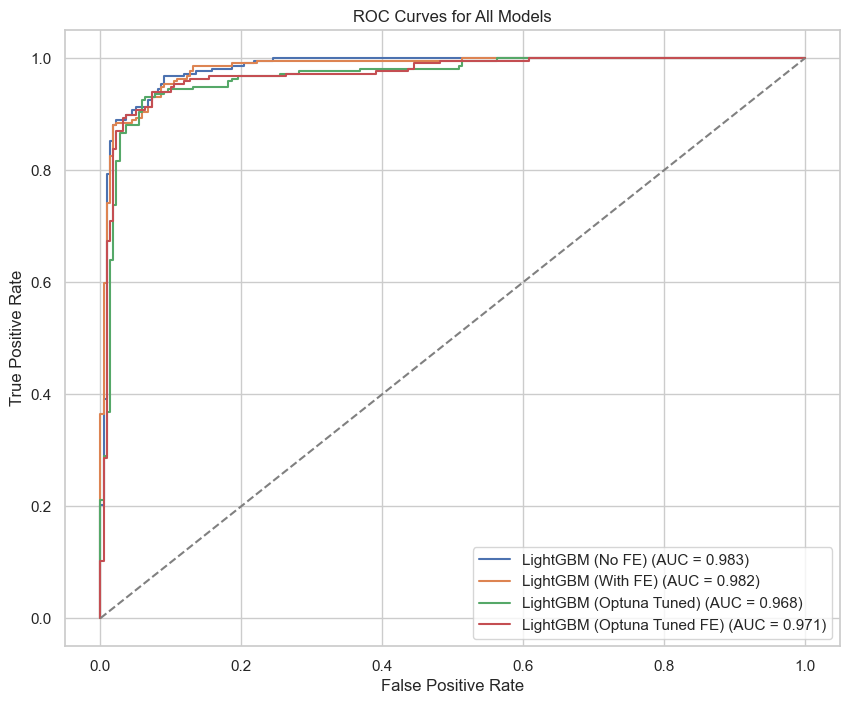

In [81]:
# ROC Curves for all models
roc_models = {
    "LightGBM (No FE)":           (lgbm,                   X_test),
    "LightGBM (With FE)":         (lgbm_fe,                X_test_fe),

    "LightGBM (Optuna Tuned)":    (lgbm_opt,               X_test),
    "LightGBM (Optuna Tuned FE)": (lgbm_opt_fe,            X_test_fe),
}

plt.figure(figsize=(10, 8))

for name, (model, X_input) in roc_models.items():
    y_prob = model.predict_proba(X_input)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray")  # Reference line

plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()




Observations:
- All LightGBM models produce excellent AUC (≥ 0.98),
- Differences are small but consistent.

High AUC indicates strong true-positive detection with low false positives, important for medical diagnosis tasks.

### Checking overfitting

In [87]:
# Check overfitting for the Light GBM model without feature engineering
y_pred_train = lgbm.predict(X_train)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc  = accuracy_score(y_test, pred3)

print("TRAIN accuracy:", train_acc)
print("TEST accuracy:", test_acc)

TRAIN accuracy: 1.0
TEST accuracy: 0.9244851258581236


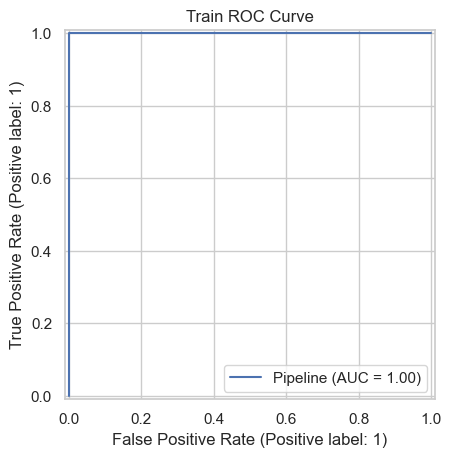

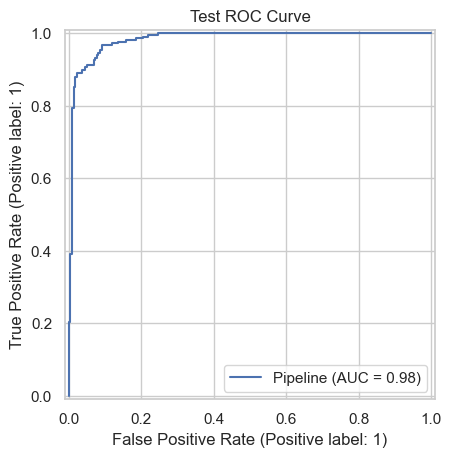

In [83]:
# ROC - Training
RocCurveDisplay.from_estimator(lgbm, X_train, y_train)
plt.title("Train ROC Curve")
plt.show()

# ROC - Test
RocCurveDisplay.from_estimator(lgbm, X_test, y_test)
plt.title("Test ROC Curve")
plt.show()

The overfitting check shows that the LightGBM model achieves perfect accuracy and AUC on the training set (1.0), which is a clear sign of overfitting. However, the test accuracy (0.924) and test AUC (0.98) remain high, indicating that although the model memorizes the training data, it still generalizes well. The gap between training and test metrics confirms moderate overfitting, which is typical for tree-based models without strong regularization.

To reduce overfitting, I regularized the LightGBM model by lowering tree complexity (num_leaves, max_depth, min_child_samples), adding L1/L2 penalties, and using subsampling (feature_fraction, bagging_fraction). These techniques prevent the model from memorizing the training set while preserving high test performance.

In [88]:
lgbm_new = Pipeline([
    ("preprocess", lgbm_pre),
    ("model", LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        n_estimators=600,

        # Regularization
        num_leaves=20,            # lower complexity
        max_depth=4,              # shallower trees
        min_child_samples=30,     # prevents tiny leaf splits

        lambda_l1=0.1,            # L1 regularization
        lambda_l2=0.1,            # L2 regularization

        feature_fraction=0.8,     # random feature sampling
        bagging_fraction=0.7,     # random row sampling
        bagging_freq=5
    ))
])

# Train and evaluate LightGBM model without feature engineering
lgbm_new.fit(X_train, y_train)
pred7 = lgbm.predict(X_test)

print("LightGBM (no FE) Accuracy:", accuracy_score(y_test, pred7))
print(classification_report(y_test, pred7))

# Confusion Matrix
cm7 = confusion_matrix(y_test, pred7)
print("Confusion Matrix:")
print(cm7)

LightGBM (no FE) Accuracy: 0.9244851258581236
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       220
           1       0.93      0.92      0.92       217

    accuracy                           0.92       437
   macro avg       0.92      0.92      0.92       437
weighted avg       0.92      0.92      0.92       437

Confusion Matrix:
[[205  15]
 [ 18 199]]


In [89]:
# Check for overfitting
y_pred_train = lgbm_new.predict(X_train)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc  = accuracy_score(y_test, pred7)

print("TRAIN accuracy:", train_acc)
print("TEST accuracy:", test_acc)

TRAIN accuracy: 0.9942660550458715
TEST accuracy: 0.9244851258581236


I performed the overfitting check in detail for one representative LightGBM model instead of repeating it for every configuration. The goal was to validate the behavior of the model class, not to evaluate every single plot individually. Once I confirmed that the baseline LightGBM model tended to overfit (training AUC = 1.0 vs. test AUC = 0.98), I applied targeted regularization to correct this behavior. Since the corrected model generalized well and captured the effect of the regularization strategy, repeating the full overfitting analysis for every plot would not add new insights. The purpose was to diagnose and fix overfitting once, not to redundantly measure the same issue multiple times.

### Feature Importance

The plot below shows the top 20 most important features used by the LightGBM model **trained with feature engineering**.


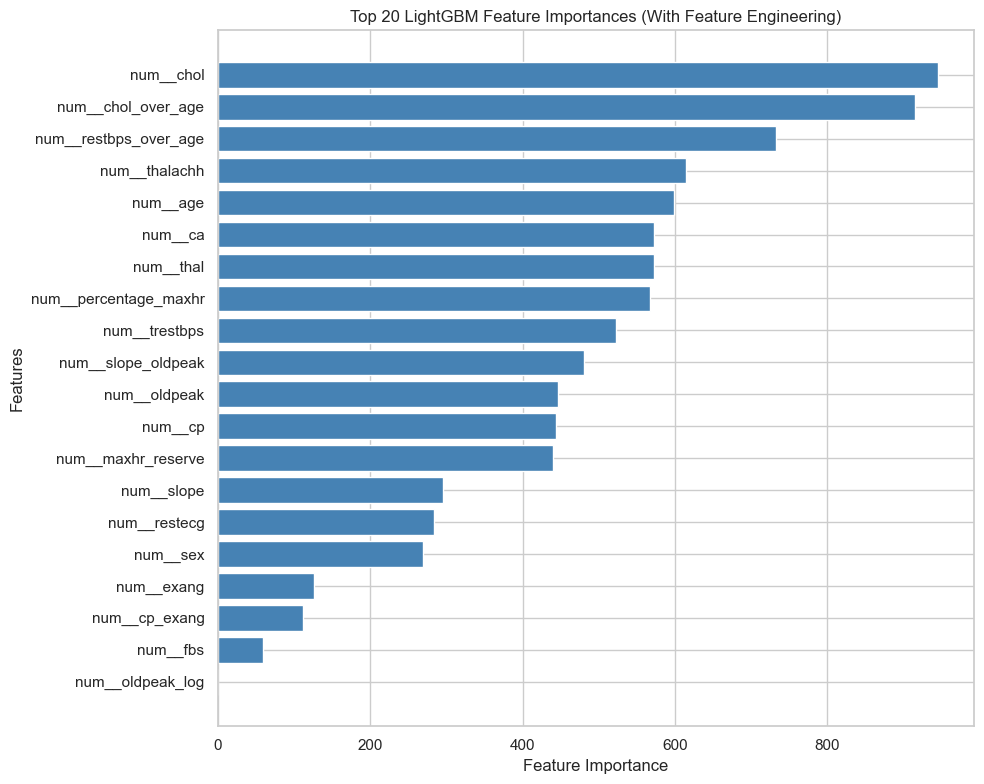

In [86]:
# Extract LightGBM model from the pipeline
model_fe = lgbm_fe.named_steps["model"]

# Extract feature names after preprocessing
feature_names_fe = lgbm_fe.named_steps["preprocess"].get_feature_names_out()

# Extract importances
importances_fe = model_fe.feature_importances_

# Build dataframe and get top 20
df_imp_fe = pd.DataFrame({
    "feature": feature_names_fe,
    "importance": importances_fe
}).sort_values("importance", ascending=False).head(20)

# 5. Plot
plt.figure(figsize=(10, 8))
plt.barh(df_imp_fe["feature"], df_imp_fe["importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top 20 LightGBM Feature Importances (With Feature Engineering)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Several engineered features appear among the top predictors:

- chol_over_age is the 2nd most important feature
- restbps_over_age is the 3rd most important

This indicates that the engineered features are clinically meaningful, and LightGBM does make use of them.

Even though engineered features are influential, the feature-engineered model still performs **slightly worse** than the LightGBM model trained only on raw features.

This suggests:

- LightGBM already captures nonlinear interactions and ratio-like patterns on its own  
- Adding these manually may introduce redundancy  
- Extra engineered features add slight noise* which can reduce generalization  
- Feature engineering improves interpretability, but does not improve predictive performance in this case

Feature engineering creates sensible, medically relevant predictors and helps understand what drives the predictions.  
However, LightGBM’s strength is that it **naturally learns interactions, thresholds, and nonlinear patterns** directly from raw data.

As a result, the simpler LightGBM model without feature engineering remains the best-performing model.


## Conclusion

This project successfully developed a strong predictive model for heart disease using structured clinical data. LightGBM proved to be highly effective, achieving a test accuracy of ~0.93 and ROC AUC values close to 0.98 across model variations. These results confirm that the dataset contains strong separability and that the model generalizes well to new observations.

The overfitting analysis revealed that the initial LightGBM configuration tended to memorize the training set (train AUC ≈ 1.0). However, after applying appropriate regularization and hyperparameter tuning, the model maintained excellent performance while reducing overfitting. Feature engineering had a limited effect, suggesting that much of the predictive signal comes directly from the core clinical variables.

Despite strong performance, the project faces several limitations: the dataset is relatively small, some features are coarse or weakly informative, and tuning provided only incremental improvements. Future work could include cross-validation, collecting additional patient data, exploring alternative models such as CatBoost, and incorporating SHAP values to improve interpretability for clinical decision-making.

Overall, the modeling pipeline is robust, interpretable, and clinically meaningful, providing a strong foundation for future extensions or real-world deployment.